# Gastrointestinal disease Detection and classification

In [1]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")



In [ ]:
# Removed deprecated TensorFlow logging settings
dataset_path = "/content/drive/MyDrive/Dataset/kvasir-dataset-v2"
# val_dataset_path = "unsplit-dataset"
image_size = (224, 224)
batch_size = 64
# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

class_names = train_ds.class_names



In [ ]:
# Split validation dataset into validation and test sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [ ]:
# Optimize dataset loading with prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Build the model
model = Sequential()
base_model = tf.keras.applications.ResNet101V2(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",  # Changed to None for logits output
)

In [ ]:
# Set base model to trainable
for layer in base_model.layers:
        layer.trainable=True

model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Added a dense layer for feature extraction
model.add(Dense(8, activation='softmax'))

In [ ]:
# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,679,752 (166.63 MB)

 Trainable params: 43,582,088 (166.25 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
best = ModelCheckpoint(filepath="best/model_best_val_accuracy.weights.h5",
                        save_weights_only=True, monitor="val_accuracy", mode="max", save_best_only=True)
# early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# Train the model
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[reduce_lr, best])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5353 - loss: 1.2654 - precision: 0.6947 - recall: 0.4145 - val_accuracy: 0.1109 - val_loss: 9864.3535 - val_precision: 0.1109 - val_recall: 0.1109 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7372 - loss: 0.6949 - precision: 0.7757 - recall: 0.6622 - val_accuracy: 0.1359 - val_loss: 3862.8228 - val_precision: 0.1359 - val_recall: 0.1359 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7761 - loss: 0.6211 - precision: 0.8069 - recall: 0.7072 - val_accuracy: 0.1109 - val_loss: 873.7574 - val_precision: 0.1109 - val_recall: 0.1109 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8297 - loss: 0.4411 - precision: 0.8352 - recall: 0.8106 - val_accuracy: 0.1906 - val_loss: 10.6286 - val_precision: 0.1899 - val_recall: 0.1828 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accur

In [ ]:
# Save the model
model.save("finalwithhighaccuracy.h5")

In [ ]:

# Extract training history
metrics = history.history
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']


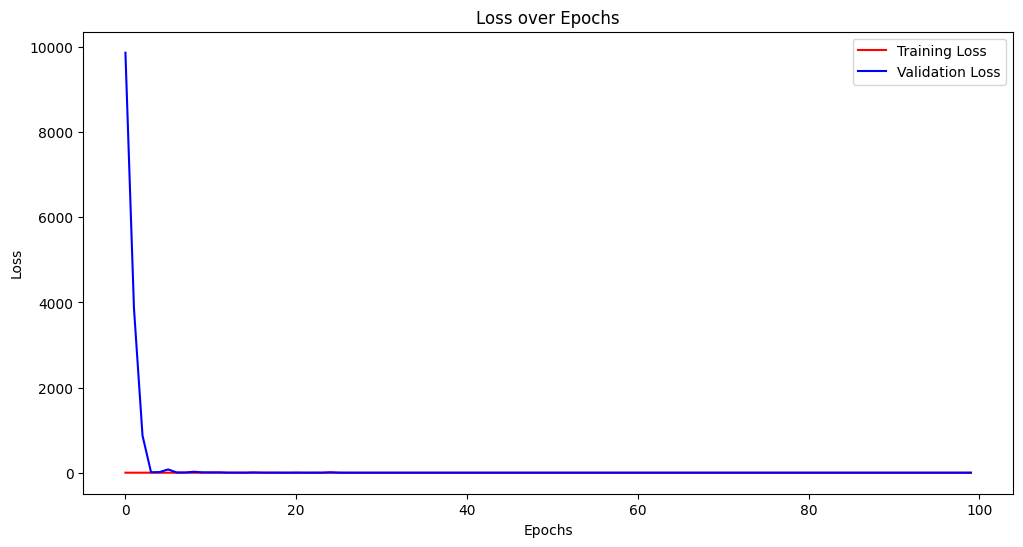

In [ ]:
# Calculate F1 scores
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




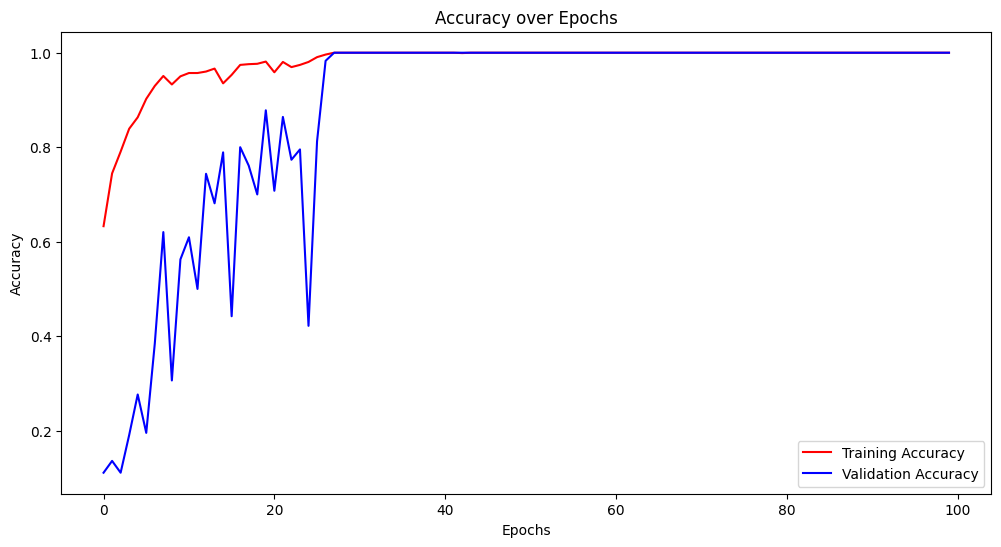

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



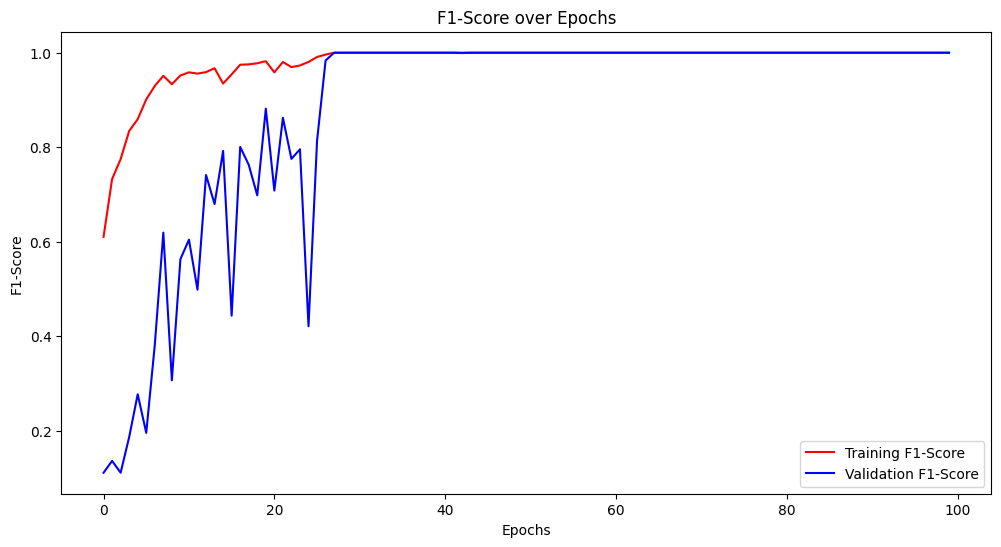

In [ ]:
# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [ ]:
# Evaluate on test data
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    plt.imshow(images)
    print('Real label:', true_labels[labels])
    print('Predicted label:', predicted_labels[labels])

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Test Accuracy: 1.00


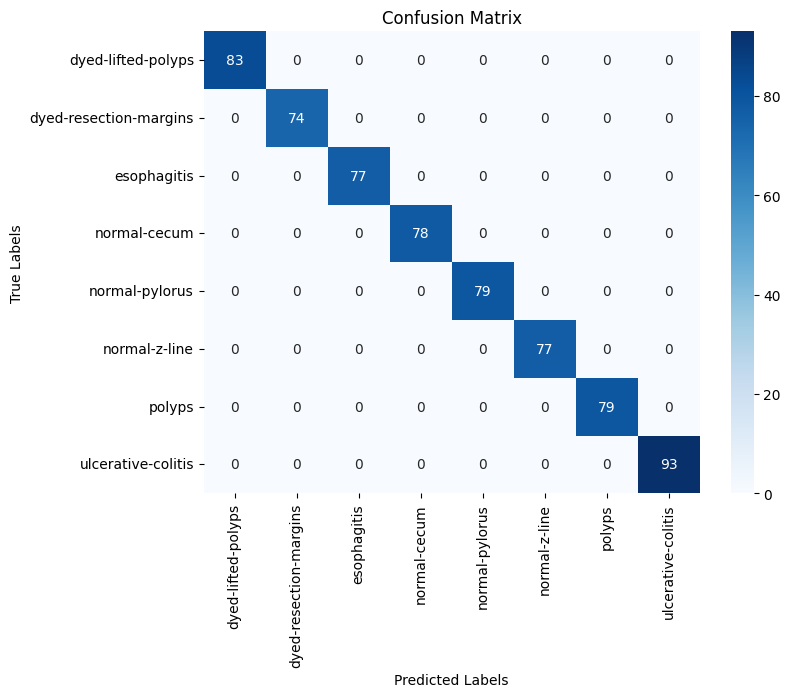


Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       1.00      1.00      1.00        83
dyed-resection-margins       1.00      1.00      1.00        74
           esophagitis       1.00      1.00      1.00        77
          normal-cecum       1.00      1.00      1.00        78
        normal-pylorus       1.00      1.00      1.00        79
         normal-z-line       1.00      1.00      1.00        77
                polyps       1.00      1.00      1.00        79
    ulcerative-colitis       1.00      1.00      1.00        93

              accuracy                           1.00       640
             macro avg       1.00      1.00      1.00       640
          weighted avg       1.00      1.00      1.00       640



In [ ]:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [ ]:
# Function to preprocess a single image for prediction
def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)

# Test image path (replace with an actual image path from your dataset)
test_image_path = '/content/drive/MyDrive/Dataset/validation-dataset/dyed-lifted-polyps/2.jpg'  # Example

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Predict logits from the model
logits = model.predict(test_image)

# Apply Softmax to get probabilities
softmax_values = tf.nn.softmax(logits[0]).numpy()

# Display class probabilities
print("Softmax Probabilities for 8 Classes:")
for class_name, prob in zip(class_names, softmax_values):
    print(f"{class_name}: {prob:.4f}")

# Get the predicted class
predicted_class = class_names[np.argmax(softmax_values)]
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Softmax Probabilities for 8 Classes:
dyed-lifted-polyps: 0.1097
dyed-resection-margins: 0.1192
esophagitis: 0.1081
normal-cecum: 0.1084
normal-pylorus: 0.1079
normal-z-line: 0.1100
polyps: 0.1350
ulcerative-colitis: 0.2017
Predicted Class: ulcerative-colitis


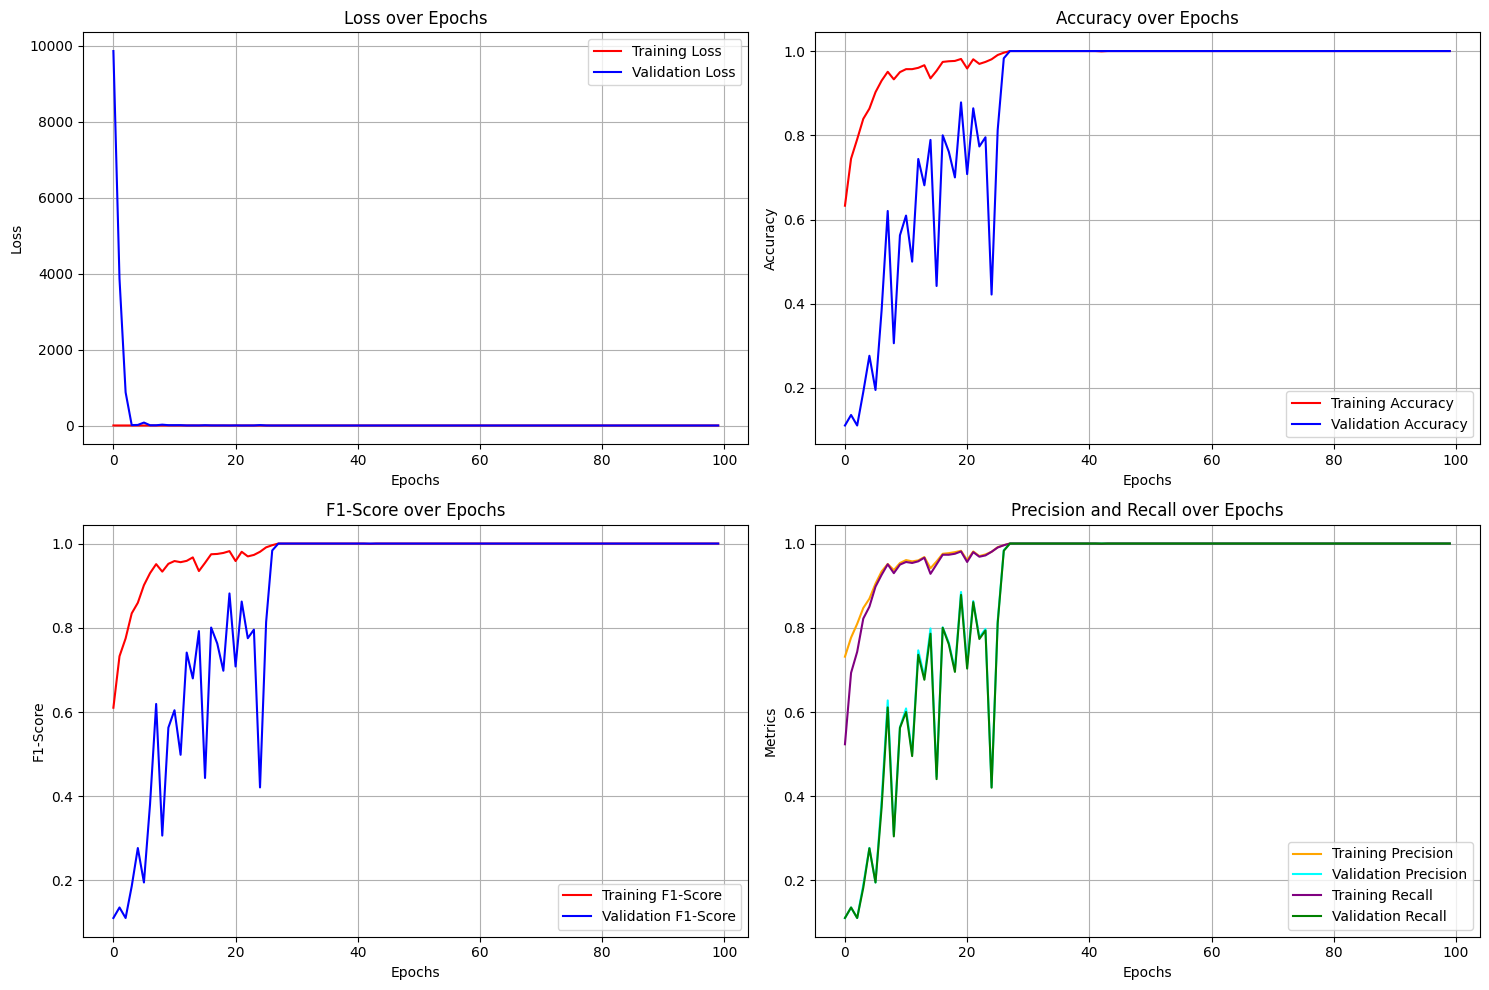

In [ ]:
# Overall analysis

# Extract metrics from the training history
metrics = history.history

# Training and validation metrics
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']

# Calculate F1-Score for Training and Validation
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Create a figure for overall performance
plt.figure(figsize=(15, 10))

# Subplot 1: Loss
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Subplot 3: F1-Score
plt.subplot(2, 2, 3)
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.grid()

# Subplot 4: Precision and Recall
plt.subplot(2, 2, 4)
plt.plot(precision, label='Training Precision', color='orange')
plt.plot(val_precision, label='Validation Precision', color='cyan')
plt.plot(recall, label='Training Recall', color='purple')
plt.plot(val_recall, label='Validation Recall', color='green')
plt.title('Precision and Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()
